In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model 
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('multi_share.csv')

In [3]:
df.head()

,Vote_Share,WinLose
0,0.039522,0
1,0.040449,0
2,0.046462,0
3,0.048306,0
4,0.079308,0


([<matplotlib.axis.YTick at 0x1e0e263ff28>,
 <a list of 2 Text yticklabel objects>)

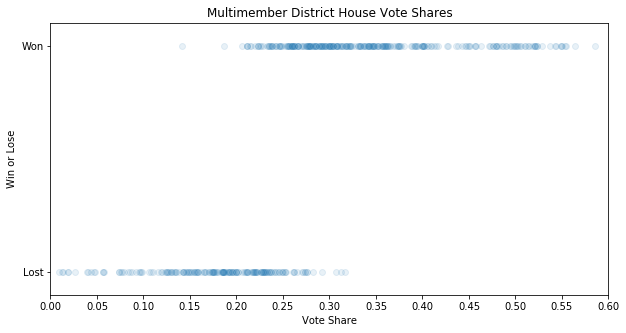

In [4]:
plt.figure(figsize=(10, 5))
plt.xticks(np.arange(0, .61, .05))
plt.yticks([0,1])

plt.scatter(df.Vote_Share, df.WinLose, alpha=.1)
plt.ylabel('Win or Lose')
plt.xlabel('Vote Share')
plt.title('Multimember District House Vote Shares')
plt.ylim(-.1, 1.1)
plt.xlim(0, .6)
plt.yticks([0,1], ['Lost', 'Won'])

In [5]:
min(df.Vote_Share[df.WinLose==1])

0.14149999999999999

In [6]:
max(df.Vote_Share[df.WinLose==0])

0.31641154799999999

In [7]:
import pymc3 as pm
import theano.tensor as tt

In [8]:
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*df['Vote_Share'] + alpha)))

In [9]:
with model:
    observed = pm.Bernoulli("bernoulli_obs", p, observed=df['WinLose'])
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(220000, step=step, start=start)
    burned_trace = trace[200000::2]
    
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]

logp = -124.29, ||grad|| = 1.4202: 100%|█████████████████████████████████████████████| 18/18 [00:00<00:00, 1152.09it/s]
100%|████████████████████████████████████████████████████████████████████████| 220500/220500 [02:00<00:00, 1834.90it/s]


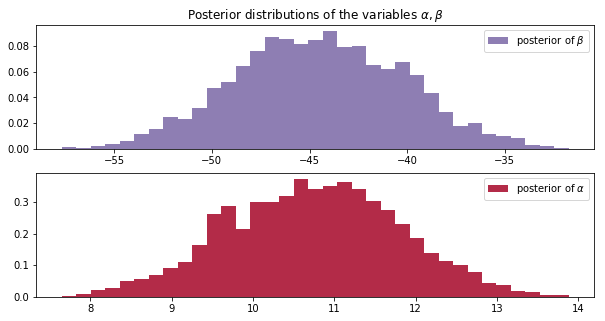

In [10]:
plt.figure(figsize=(10, 5))

#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend();

In [11]:
def logistic(x, beta, alpha=0):
    '''Logistic Function'''
    
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

t = np.linspace(df['Vote_Share'].min(), df['Vote_Share'].max(), 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

In [74]:
logistic(.241, beta_samples, alpha_samples).mean(axis=0)

array([ 0.49804279])

In [88]:
logistic(.3084, beta_samples, alpha_samples).mean(axis=0)

array([ 0.95005618])

In [101]:
logistic(.2912111, beta_samples, alpha_samples).mean(axis=0)

array([ 0.90021951])

In [70]:
logistic(.25, beta_samples, alpha_samples).mean(axis=0)

array([ 0.59627588])

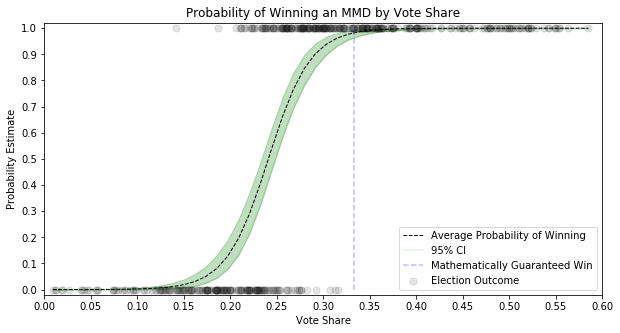

In [89]:
from scipy.stats.mstats import mquantiles
plt.figure(figsize=(10, 5))

# vectorized bottom and top 2.5% quantiles for confidence interval
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.25,
                 color="green")


plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="Average Probability of Winning")
plt.plot(t[:, 0], qs[0], label="95% CI", color="green", alpha=.1)
plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.scatter(df['Vote_Share'], df['WinLose'], color="k", s=50, alpha=0.1, label='Election Outcome')
plt.xlabel("Vote Share")
plt.yticks(np.arange(0,1.01,.1))
plt.xticks(np.arange(0, .61, .05))
#plt.plot([0, 1], [.498, .498])
#plt.plot([.241, .241], [0, 1])

plt.plot([.3334, .3334], [0,1], ls='--', color='blue', alpha=.25,
         label='Mathematically Guaranteed Win')
plt.legend(loc="lower right")
plt.ylabel("Probability Estimate")
plt.title("Probability of Winning an MMD by Vote Share")
plt.savefig('results.png')